In [1]:
!pip install matplotlib wordcloud


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, BatchNormalization, Input, Embedding, Dot, Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

from wordcloud import WordCloud

from collections import defaultdict
# %matplotlib inline

### READING ANIMELIST.CSV

In [3]:
import os

In [4]:
INPUT_DIR = os.path.join("../", "artifacts/", "raw/")

In [5]:
rating_df = pd.read_csv(INPUT_DIR+"animelist.csv", low_memory=True, usecols=["user_id", "anime_id", "rating"])
rating_df.head()

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


In [6]:
rating_df.shape

(5000000, 3)

### DATA PROCESSING

In [7]:
n_ratings = rating_df.user_id.value_counts()
n_ratings

user_id
11100    14429
10255     8403
4773      5735
6852      5406
16057     5080
         ...  
106          1
6846         1
92           1
26           1
10703        1
Name: count, Length: 15186, dtype: int64

In [8]:
rating_df = rating_df[rating_df['user_id'].isin(n_ratings[n_ratings >=30].index)].copy()

In [9]:
rating_df.shape

(4980916, 3)

In [10]:
rating_df

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10
...,...,...,...
4999995,16508,21405,8
4999996,16508,24913,9
4999997,16508,37451,7
4999998,16508,28755,8


In [11]:
min_rating = min(rating_df["rating"])
max_rating = max(rating_df["rating"])

print(f"Min. Rating: {min_rating} \nMax. Rating: {max_rating}")

Min. Rating: 0 
Max. Rating: 10


In [12]:
avg_rating = np.mean(rating_df["rating"])

print(f"Min. Rating: {avg_rating:.2f}")

Min. Rating: 4.30


#### Mean Max Feature Scaling to scale the ratings from 0 - 10 to 0 - 1

In [13]:
rating_df["rating"] = rating_df["rating"].apply(lambda x: (x-min_rating)/(max_rating-min_rating)).values.astype(np.float64)

In [14]:
min_rating = min(rating_df["rating"])
max_rating = max(rating_df["rating"])
avg_rating = np.mean(rating_df["rating"])
print(f"Min. Rating: {min_rating} \nMax. Rating: {max_rating} \nMin. Rating: {avg_rating:.3f}")

Min. Rating: 0.0 
Max. Rating: 1.0 
Min. Rating: 0.430


In [15]:
rating_df.duplicated().sum()

np.int64(0)

In [16]:
rating_df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

#### Encoding User IDs

In [17]:
user_id = rating_df["user_id"].unique().tolist()
user2user_encoded = {x: i for i, x in  enumerate(user_id)}
user2user_decoded = {i: x for i, x in  enumerate(user_id)}

In [18]:
print(user2user_encoded)
print(user2user_decoded)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 11: 9, 12: 10, 13: 11, 14: 12, 15: 13, 16: 14, 17: 15, 18: 16, 19: 17, 20: 18, 21: 19, 22: 20, 23: 21, 25: 22, 27: 23, 28: 24, 29: 25, 30: 26, 32: 27, 33: 28, 34: 29, 36: 30, 37: 31, 38: 32, 39: 33, 40: 34, 41: 35, 42: 36, 44: 37, 45: 38, 46: 39, 47: 40, 48: 41, 49: 42, 50: 43, 51: 44, 52: 45, 53: 46, 54: 47, 55: 48, 56: 49, 57: 50, 58: 51, 59: 52, 60: 53, 61: 54, 62: 55, 63: 56, 64: 57, 65: 58, 66: 59, 67: 60, 68: 61, 70: 62, 71: 63, 72: 64, 73: 65, 74: 66, 75: 67, 78: 68, 79: 69, 80: 70, 81: 71, 82: 72, 83: 73, 84: 74, 85: 75, 88: 76, 89: 77, 90: 78, 91: 79, 93: 80, 94: 81, 97: 82, 98: 83, 99: 84, 101: 85, 102: 86, 103: 87, 107: 88, 108: 89, 110: 90, 111: 91, 112: 92, 113: 93, 117: 94, 119: 95, 120: 96, 121: 97, 122: 98, 123: 99, 124: 100, 125: 101, 126: 102, 127: 103, 128: 104, 129: 105, 130: 106, 131: 107, 133: 108, 134: 109, 135: 110, 136: 111, 137: 112, 138: 113, 139: 114, 143: 115, 145: 116, 146: 117, 147: 118, 148: 119, 152

In [19]:
len(user2user_encoded)

13645

In [20]:
rating_df["user"] = rating_df["user_id"].map(user2user_encoded)
rating_df

,user_id,anime_id,rating,user
0,0,67,0.9,0
1,0,6702,0.7,0
2,0,242,1.0,0
3,0,4898,0.0,0
4,0,21,1.0,0
...,...,...,...,...
4999995,16508,21405,0.8,13644
4999996,16508,24913,0.9,13644
4999997,16508,37451,0.7,13644
4999998,16508,28755,0.8,13644


#### Encoding Anime IDs

In [21]:
anime_id = rating_df["anime_id"].unique().tolist()
anime2anime_encoded = {x: i for i, x in enumerate(anime_id)}
anime2anime_decoded = {i: x for i, x in enumerate(anime_id)}

In [22]:
print(anime2anime_encoded)
print(anime2anime_decoded)
print(len(anime2anime_encoded))

{67: 0, 6702: 1, 242: 2, 4898: 3, 21: 4, 24: 5, 2104: 6, 4722: 7, 6098: 8, 3125: 9, 481: 10, 68: 11, 1689: 12, 2913: 13, 1250: 14, 356: 15, 121: 16, 430: 17, 1829: 18, 1571: 19, 578: 20, 431: 21, 2762: 22, 570: 23, 3418: 24, 3010: 25, 1004: 26, 433: 27, 600: 28, 2034: 29, 164: 30, 4086: 31, 457: 32, 20: 33, 1074: 34, 761: 35, 2248: 36, 597: 37, 1047: 38, 459: 39, 466: 40, 2543: 41, 419: 42, 199: 43, 169: 44, 2547: 45, 174: 46, 448: 47, 2236: 48, 415: 49, 1894: 50, 269: 51, 235: 52, 71: 53, 245: 54, 134: 55, 1887: 56, 3457: 57, 1535: 58, 1726: 59, 228: 60, 1735: 61, 1482: 62, 5114: 63, 256: 64, 19: 65, 877: 66, 272: 67, 853: 68, 177: 69, 1985: 70, 202: 71, 2006: 72, 482: 73, 37403: 74, 9989: 75, 24833: 76, 7674: 77, 34572: 78, 34566: 79, 2167: 80, 40852: 81, 10087: 82, 38680: 83, 40052: 84, 40748: 85, 1604: 86, 20507: 87, 38483: 88, 26243: 89, 42203: 90, 40028: 91, 39551: 92, 39617: 93, 3972: 94, 22199: 95, 6547: 96, 9919: 97, 5081: 98, 31043: 99, 31964: 100, 33486: 101, 36456: 102, 384

In [23]:
rating_df["anime"] = rating_df["anime_id"].map(anime2anime_encoded)
rating_df

,user_id,anime_id,rating,user,anime
0,0,67,0.9,0,0
1,0,6702,0.7,0,1
2,0,242,1.0,0,2
3,0,4898,0.0,0,3
4,0,21,1.0,0,4
...,...,...,...,...,...
4999995,16508,21405,0.8,13644,1071
4999996,16508,24913,0.9,13644,2596
4999997,16508,37451,0.7,13644,3417
4999998,16508,28755,0.8,13644,104


#### Introduce Randomness to the DataFrame


In [24]:
rating_df = rating_df.sample(frac=1, random_state=43).reset_index(drop=True)

#### Splitting the DataFrame into Input and Output Features

In [25]:
rating_df.head(2)

,user_id,anime_id,rating,user,anime
0,12930,30016,0.6,10676,1583
1,6791,2904,0.0,5591,220


In [26]:
X = rating_df[["user", "anime"]].values
y = rating_df["rating"]

#### Splitting the DataFrame into Train and Test Sets

In [27]:
test_size = 1000
train_indices = rating_df.shape[0] - test_size

In [28]:
X_train, X_test, y_train, y_test = (
    X[:train_indices],
    X[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

In [29]:
print(f"Length X_train: {len(X_train)} \nLength X_test: {len(X_test)}")

Length X_train: 4979916 
Length X_test: 1000


In [30]:
type(X_train)

numpy.ndarray

#### Creating Arrays for User and Anime Features

In [31]:
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [32]:
X_train_array

[array([10676,  5591, 12171, ..., 12849,  9358,  7673]),
 array([1583,  220, 3003, ...,  312, 4876,  709])]

In [33]:
type(X_train_array[0])

numpy.ndarray

### MODEL ARCHITECTURE  

In [34]:
def RecommenderNet():
    embedding_size = 128  # size of the dense embedding vectors for both users and items

    # input for the user ID, shape [1] means one integer per example
    user = Input(name="user", shape=[1])
    # map each user ID to a dense vector of length embedding_size
    user_embedding = Embedding(
        name="user_embedding",
        input_dim=len(user_id),  # number of unique users
        output_dim=embedding_size  # dimension of embedding
    )(user)

    # input for the anime ID, one integer per example
    anime = Input(name="anime", shape=[1])
    # map each anime ID to a dense vector of length embedding_size
    anime_embedding = Embedding(
        name="anime_embedding",
        input_dim=len(anime_id),  # number of unique anime titles
        output_dim=embedding_size  # dimension of embedding
    )(anime)

    # compute cosine similarity between user and anime embeddings
    # axes=2 means we match on the embedding dimension
    x = Dot(name="dot_product", normalize=True, axes=2)(
        [user_embedding, anime_embedding]
    )

    # Flatten turns the result from shape (batch, 1, 1) into (batch, 1)
    x = Flatten()(x)

    # final dense layer to produce a single score per user–anime pair
    x = Dense(
        1,
        kernel_initializer="he_normal"  # He normal initializer for the weights
    )(x)
    # normalise the output distribution
    x = BatchNormalization()(x)
    # convert the output score into a probability between 0 and 1
    x = Activation("sigmoid")(x)

    # assemble the model, specifying inputs and outputs
    model = Model(inputs=[user, anime], outputs=x)
    # compile with binary crossentropy loss, track mae and mse, and use Adam optimizer
    model.compile(
        loss="binary_crossentropy",
        metrics=["mae", "mse"],
        optimizer="Adam"
    )

    return model


In [35]:
model = RecommenderNet()

In [36]:
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │  1,746,560 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,196,352 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │          2 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1)         │          4 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,942,918 (15.04 MB)

 Trainable params: 3,942,916 (15.04 MB)

 Non-trainable params: 2 (8.00 B)

#### Callbacks

In [37]:
start_lr = 0.0001
min_lr = 0.0001
max_lr = 0.001
batch_size = 10000

ramup_epochs = 5
sustain_epochs = 0
exp_decay = 0.8

def lrfn(epoch):
    '''This functions helps to find the best learning rate for the model'''
    if epoch < ramup_epochs:
        return (max_lr-start_lr)/ramup_epochs*epoch + start_lr
    elif epoch < ramup_epochs + sustain_epochs:
        return max_lr
    else:
        return(max_lr-min_lr) * exp_decay**(epoch-ramup_epochs-sustain_epochs) + min_lr 

In [38]:
lr_callback = LearningRateScheduler(lambda epoch:lrfn(epoch), verbose=0)

checkpoint_filepath = "./weights.weights.h5"
model_Checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor="val_loss", mode="min", save_best_only=True)

early_stopping = EarlyStopping(patience=3, monitor="val_loss", mode="min", restore_best_weights=True)

In [39]:
my_callbacks = [model_Checkpoint, lr_callback, early_stopping]

#### Model Training

In [40]:
history = model.fit(
    x=X_train_array,
    y=y_train,
    batch_size=batch_size, 
    epochs=20,
    verbose=1,
    validation_data=(X_test_array, y_test),
    callbacks=my_callbacks
)

Epoch 1/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 35s 63ms/step - loss: 0.7990 - mae: 0.3844 - mse: 0.1985 - val_loss: 0.7782 - val_mae: 0.3849 - val_mse: 0.1919 - learning_rate: 1.0000e-04
Epoch 2/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 28s 56ms/step - loss: 0.7313 - mae: 0.3565 - mse: 0.1709 - val_loss: 0.6374 - val_mae: 0.3064 - val_mse: 0.1306 - learning_rate: 2.8000e-04
Epoch 3/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 29s 58ms/step - loss: 0.5726 - mae: 0.2718 - mse: 0.1023 - val_loss: 0.5856 - val_mae: 0.2767 - val_mse: 0.1076 - learning_rate: 4.6000e-04
Epoch 4/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 32s 63ms/step - loss: 0.5296 - mae: 0.2427 - mse: 0.0843 - val_loss: 0.5621 - val_mae: 0.2574 - val_mse: 0.0979 - learning_rate: 6.4000e-04
Epoch 5/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 32s 64ms/step - loss: 0.4938 - mae: 0.2143 - mse: 0.0702 - val_loss: 0.5487 - val_mae: 0.2390 - val_mse: 0.0933 - learning_rate: 8.2000e-04
Epoch 6/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 32s 63ms/step - loss: 0.4641 - mae: 0.1891 - mse: 0.0592 - v

##### Graphical Representation of the Model

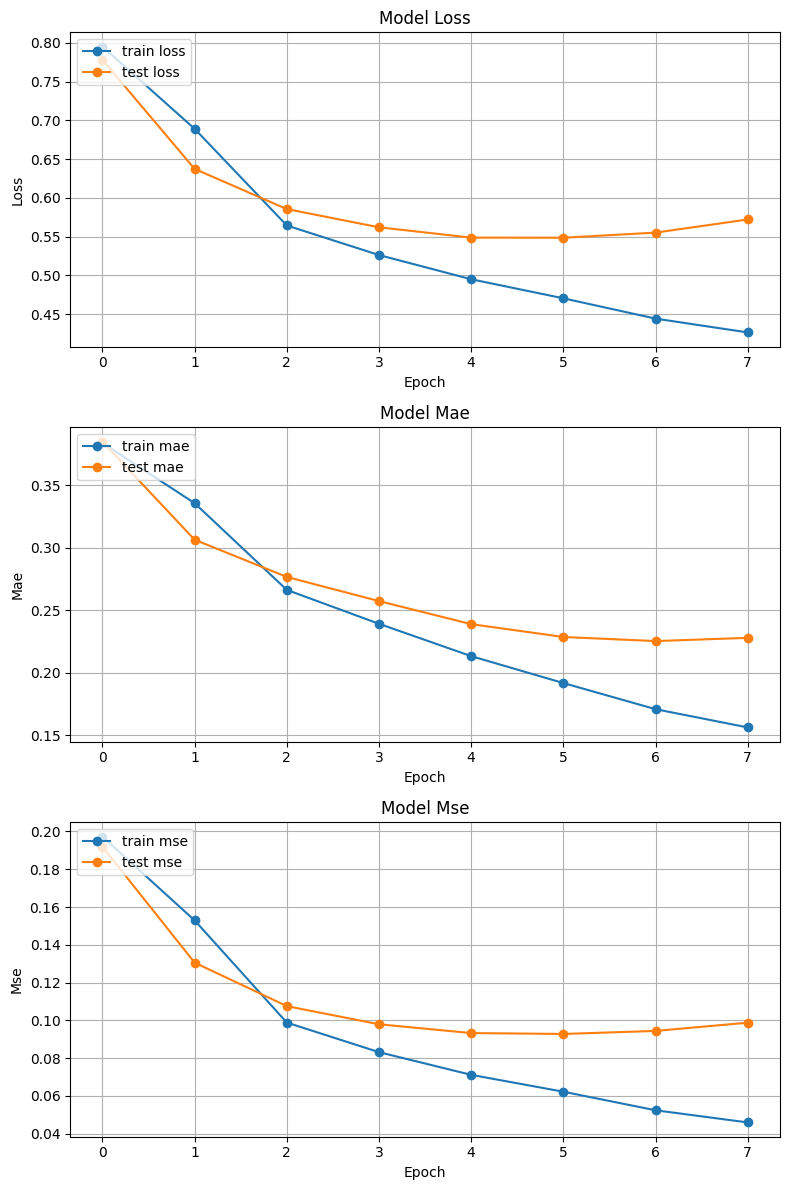

In [41]:
metrics = ["loss", "mae", "mse"]

# Create subplots
fig, axes = plt.subplots(len(metrics), 1, figsize=(8, len(metrics) * 4))

for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.plot(history.history[metric][0:-1], marker="o", label=f"train {metric}")
    ax.plot(history.history[f"val_{metric}"][0:-1], marker="o", label=f"test {metric}")
    ax.set_title(f"Model {metric.capitalize()}")
    ax.set_ylabel(metric.capitalize())
    ax.set_xlabel("Epoch")
    ax.legend(loc="upper left")
    ax.grid(True)

plt.tight_layout()
plt.show()

##### Extracting Weights

In [42]:
def extract_weights(name, model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights/np.linalg.norm(weights, axis=1).reshape((-1, 1))
    return weights

In [43]:
anime_Weights = extract_weights("anime_embedding", model=model)

In [44]:
user_Weights = extract_weights("user_embedding", model=model)

### READING ANIMELIST.CSV

In [45]:
df = pd.read_csv(INPUT_DIR + "/anime.csv", low_memory=True)
df.head(3)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0


In [46]:
df = df.replace("Unknown", np.nan)

In [47]:
df["anime_id"] = df.MAL_ID

def get_anime_name(anime_id):
    try: 
        name = df[df.MAL_ID == anime_id]["English name"].values[0]
        if name is np.nan:
            name = df[df.MAL_ID == anime_id].Name.values[0]
    except:
        print("Error")
    return name

In [48]:
df["eng_version"] = df.anime_id.apply(lambda x:get_anime_name(x))

In [49]:
df.head(5)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0,1,Cowboy Bebop
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",NaN,...,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0,5,Cowboy Bebop:The Movie
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0,6,Trigun
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0,7,Witch Hunter Robin
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0,8,Beet the Vandel Buster


In [50]:
get_anime_name(6702)

'Fairy Tail'

In [51]:
df.sort_values(by="Score", inplace=True, ascending=False, kind="quicksort", na_position="last")
df.head(7)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
3971,5114,Fullmetal Alchemist: Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",Fullmetal Alchemist:Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,TV,64,"Apr 5, 2009 to Jul 4, 2010",Spring 2009,...,199160.0,70045.0,20210.0,9308.0,3222.0,1536.0,2162.0,16806.0,5114,Fullmetal Alchemist:Brotherhood
15926,40028,Shingeki no Kyojin: The Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",Attack on Titan Final Season,進撃の巨人 The Final Season,TV,16,"Dec 7, 2020 to ?",Winter 2021,...,26016.0,8793.0,2674.0,1336.0,588.0,382.0,514.0,11061.0,40028,Attack on Titan Final Season
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",Steins;Gate,STEINS;GATE,TV,24,"Apr 6, 2011 to Sep 14, 2011",Spring 2011,...,140914.0,57740.0,21375.0,11126.0,5061.0,2292.0,1678.0,5255.0,9253,Steins;Gate
14963,38524,Shingeki no Kyojin Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",Attack on Titan Season 3 Part 2,進撃の巨人 Season3 Part.2,TV,10,"Apr 29, 2019 to Jul 1, 2019",Spring 2019,...,110481.0,33662.0,8365.0,2974.0,1108.0,550.0,385.0,4169.0,38524,Attack on Titan Season 3 Part 2
9913,28977,Gintama°,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",Gintama Season 4,銀魂°,TV,51,"Apr 8, 2015 to Mar 30, 2016",Spring 2015,...,21360.0,10215.0,3898.0,2311.0,952.0,648.0,1100.0,4508.0,28977,Gintama Season 4
6474,11061,Hunter x Hunter (2011),9.1,"Action, Adventure, Fantasy, Shounen, Super Power",Hunter x Hunter,HUNTER×HUNTER（ハンター×ハンター）,TV,148,"Oct 2, 2011 to Sep 24, 2014",Fall 2011,...,167331.0,65085.0,18241.0,7789.0,2780.0,1243.0,1054.0,4602.0,11061,Hunter x Hunter
6006,9969,Gintama',9.08,"Action, Sci-Fi, Comedy, Historical, Parody, Sa...",Gintama Season 2,銀魂',TV,51,"Apr 4, 2011 to Mar 26, 2012",Spring 2011,...,24294.0,9584.0,3222.0,1655.0,694.0,338.0,437.0,2910.0,9969,Gintama Season 2


In [52]:
df.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1', 'anime_id',
       'eng_version'],
      dtype='object')

In [53]:
df = df[["anime_id", "eng_version", "Score", "Genres", "Episodes", "Type", "Premiered", "Members"]]

In [54]:
df.head()

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",64,TV,Spring 2009,2248456
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162
14963,38524,Attack on Titan Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",10,TV,Spring 2019,1073626
9913,28977,Gintama Season 4,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",51,TV,Spring 2015,404121


In [55]:
def get_anime(df, anime):
    if isinstance(anime,int):
        return df[df.anime_id == anime]
    elif isinstance(anime, str):
        return df[df.eng_version.str.lower() == anime.lower()]

In [56]:
get_anime(df, "soul eater")

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3155,3588,Soul Eater,7.88,"Action, Fantasy, Comedy, Supernatural, Shounen",51,TV,Spring 2008,1218423


### READING ANIMEWITHSYNOPSIS.CSV

In [57]:
cols = ["MAL_ID", "Name", "Genres", "sypnopsis"]

In [58]:
synopsis_df = pd.read_csv(INPUT_DIR + "/anime_with_synopsis.csv", usecols=cols)

In [59]:
synopsis_df.head(2)

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of ..."


In [60]:
def get_synopsis(anime, df=synopsis_df):
    try:
        if isinstance(anime,int):
            return df[df["MAL_ID"] == anime]["sypnopsis"].values[0]
        elif isinstance(anime, str):
            return df[df["Name"].str.lower() == anime.lower()]["sypnopsis"].values[0]
    except IndexError:
        return 'N/A'

In [61]:
get_synopsis("Steins;gate") 
get_synopsis("Rance: Sabaku no Guardian")
# get_synopsis(5259)

'N/A'

## CONTENT/ITEM BASED RECOMMENDER SYSTEM

In [62]:
pd.set_option("max_colwidth", None)

In [63]:
def find_similar_animes(name, df=df, synopsis_df=synopsis_df, anime_Weights=anime_Weights, 
                        anime2anime_encoded=anime2anime_encoded, anime2anime_decoded=anime2anime_decoded, n=10,
                        return_dist=False, neg=False):
    try:
        index = get_anime(df, name).anime_id.values[0] #to get the natural index example >>> np.int64(2029)
        encoded_index = anime2anime_encoded.get(index)

        weights = anime_Weights

        dists = np.dot(weights, weights[encoded_index]) # find the similarity between all the anime weights and the current anime weight
        sorted_dist = np.argsort(dists) # returns an array of indices that would sort `dists` in ascending order. In other words

        n = n+1

        if neg:
            closest = sorted_dist[:n]
        else:
            closest = sorted_dist[-n:]
        
        if return_dist:
            return dists, closest
        
        SimilarityArr = []
        for close in closest:
            decoded_id = anime2anime_decoded.get(close)
            anime_frame = get_anime(df, decoded_id)
            synopsis = get_synopsis(decoded_id)
            anime_name = anime_frame["eng_version"].values[0]
            genre = anime_frame["Genres"].values[0]
            similarity = dists[close]
            

            SimilarityArr.append({
                "anime_id": decoded_id,
                "Name": anime_name,
                "Genres": genre,
                "Synopsis": synopsis,
                "similarity": similarity
            })
        
        Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)
        return Frame[Frame.anime_id != index].drop(["anime_id"], axis=1).reset_index(drop=True)

    except:
        print("Error Occured")

In [64]:
find_similar_animes("Parasyte -the maxim-")


,Name,Genres,Synopsis,similarity
0,One Punch Man,"Action, Sci-Fi, Comedy, Parody, Super Power, Supernatural","The seemingly ordinary and unimpressive Saitama has a rather unique hobby: being a hero. In order to pursue his childhood dream, he trained relentlessly for three years—and lost all of his hair in the process. Now, Saitama is incredibly powerful, so much so that no enemy is able to defeat him in battle. In fact, all it takes to defeat evildoers with just one punch has led to an unexpected problem—he is no longer able to enjoy the thrill of battling and has become quite bored. This all changes with the arrival of Genos, a 19-year-old cyborg, who wishes to be Saitama's disciple after seeing what he is capable of. Genos proposes that the two join the Hero Association in order to become certified heroes that will be recognized for their positive contributions to society, and Saitama, shocked that no one knows who he is, quickly agrees. And thus begins the story of One Punch Man , an action-comedy that follows an eccentric individual who longs to fight strong enemies that can hopefully give him the excitement he once felt and just maybe, he'll become popular in the process.",0.580903
1,Attack on Titan,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen","Centuries ago, mankind was slaughtered to near extinction by monstrous humanoid creatures called titans, forcing humans to hide in fear behind enormous concentric walls. What makes these giants truly terrifying is that their taste for human flesh is not born out of hunger but what appears to be out of pleasure. To ensure their survival, the remnants of humanity began living within defensive barriers, resulting in one hundred years without a single titan encounter. However, that fragile calm is soon shattered when a colossal titan manages to breach the supposedly impregnable outer wall, reigniting the fight for survival against the man-eating abominations. After witnessing a horrific personal loss at the hands of the invading creatures, Eren Yeager dedicates his life to their eradication by enlisting into the Survey Corps, an elite military unit that combats the merciless humanoids outside the protection of the walls. Based on Hajime Isayama's award-winning manga, Shingeki no Kyojin follows Eren, along with his adopted sister Mikasa Ackerman and his childhood friend Armin Arlert, as they join the brutal war against the titans and race to discover a way of defeating them before the last walls are breached.",0.578673
2,Tokyo Ghoul,"Action, Mystery, Horror, Psychological, Supernatural, Drama, Seinen","Tokyo has become a cruel and merciless city—a place where vicious creatures called ""ghouls"" exist alongside humans. The citizens of this once great metropolis live in constant fear of these bloodthirsty savages and their thirst for human flesh. However, the greatest threat these ghouls pose is their dangerous ability to masquerade as humans and blend in with society. Based on the best-selling supernatural horror manga by Sui Ishida, Tokyo Ghoul follows Ken Kaneki, a shy, bookish college student, who is instantly drawn to Rize Kamishiro, an avid reader like himself. However, Rize is not exactly who she seems, and this unfortunate meeting pushes Kaneki into the dark depths of the ghouls' inhuman world. In a twist of fate, Kaneki is saved by the enigmatic waitress Touka Kirishima, and thus begins his new, secret life as a half-ghoul/half-human who must find a way to integrate into both societies.",0.526442
3,"No Game, No Life","Game, Adventure, Comedy, Supernatural, Ecchi, Fantasy","No Game No Life is a surreal comedy that follows Sora and Shiro, shut-in NEET siblings and the online gamer duo behind the legendary username ""Blank."" They view the real world as just another lousy game; however, a strange e-mail challenging them to a chess match changes everything—the brother and sister are plunged into an otherworldly realm where they meet Tet, the God of Games. The mys

## USER BASED RECOMMENDATION 

In [65]:
def find_similar_users(item_input:int, user_Weights=user_Weights, 
                       user2user_encoded=user2user_encoded, user2user_decoded=user2user_decoded,
                       n=10, return_dist=False, neg=False):
    
    try:
        index = item_input
        encoded_index = user2user_encoded.get(index)

        weights = user_Weights

        dists = np.dot(weights, weights[encoded_index])
        sorted_dists = np.argsort(dists) # returns an array of indices that would sort `dists` in ascending order. In other words

        n = n+1

        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]
        
        if return_dist:
            return dists, closest
        
        SimilarityArr = []

        for close in closest:
            similarity = dists[close]

            if isinstance(item_input, int):
                decoded_id = user2user_decoded.get(close)
                SimilarityArr.append({
                    "similar_users": decoded_id,
                    "similarity": similarity,
                })
        
        similar_users = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)
        return similar_users[similar_users["similar_users"] != index].reset_index(drop=True)
    
    except Exception as e:
        print("Error Occured", e)

In [66]:
find_similar_users(item_input=11880)

,similar_users,similarity
0,13815,0.473018
1,1999,0.459643
2,5586,0.438596
3,5182,0.435470
4,4199,0.426486
5,9437,0.424942
6,15062,0.424862
7,12340,0.422546
8,8578,0.421732
9,6088,0.420436


In [67]:
def show_word_cloud(all_genres):
    genres_cloud = WordCloud(width=700, height=400, background_color="white", colormap="gnuplot").generate_from_frequencies(all_genres)
    plt.figure(figsize=(10,8))
    plt.imshow(genres_cloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [68]:
def get_fav_genre(frame, plot=False):
    frame.dropna(inplace=False)
    all_genres = defaultdict(int)

    genres_list = []
    for genres in frame["Genres"]:
        if isinstance(genres, str):
            for genre in genres.split(","):
                genres_list.append(genre)
                all_genres[genre.strip()] += 1 

    if plot:
        show_word_cloud(all_genres)

    return genres_list

In [69]:
rating_df.head(2)

,user_id,anime_id,rating,user,anime
0,12930,30016,0.6,10676,1583
1,6791,2904,0.0,5591,220


In [70]:
def get_user_preferences(user_id, df=df, df_r=rating_df, plot=False):
    all_animes_watched_dy_user = df_r[df_r["user_id"] == user_id]

    user_rating_percentile = np.percentile(all_animes_watched_dy_user.rating, 75) # only focusing on to rating by user
    animes_watched_dy_user = all_animes_watched_dy_user[all_animes_watched_dy_user.rating >= user_rating_percentile]

    top_animes_user = animes_watched_dy_user.sort_values(by="rating", ascending=False)["anime_id"].values
    anime_df_rows = df[df["anime_id"].isin(top_animes_user)]
    anime_df_rows = anime_df_rows[["eng_version", "Genres"]]

    watched_df_rows = df[df["anime_id"].isin(all_animes_watched_dy_user["anime_id"].values)]
    watched_df_rows = watched_df_rows[["eng_version", "Genres"]]

    if plot:
        get_fav_genre(anime_df_rows, plot)

    # print(anime_df_rows.shape, watched_df_rows.shape)
    return anime_df_rows, watched_df_rows

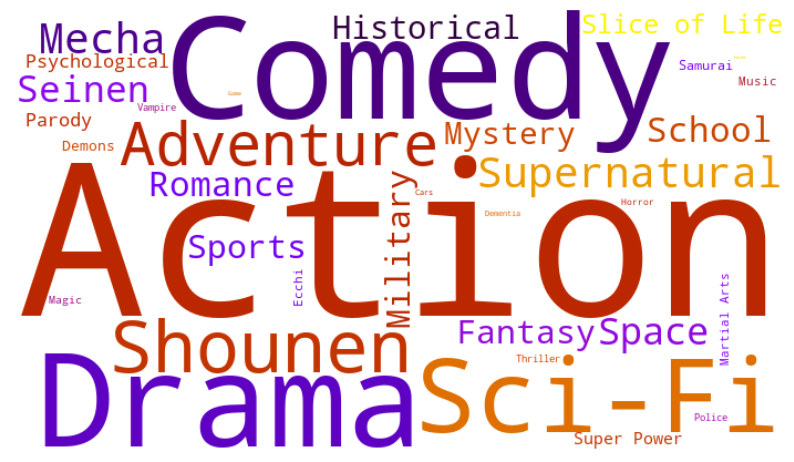

,eng_version,Genres
3971,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen"
9913,Gintama Season 4,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
6474,Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power"
6006,Gintama Season 2,"Action, Sci-Fi, Comedy, Historical, Parody, Samurai, Shounen"
741,Legend of the Galactic Heroes,"Military, Sci-Fi, Space, Drama"
...,...,...
2575,Shootfighter Tekken,"Action, Martial Arts, Shounen"
8064,Samurai Flamenco,"Action, Comedy, Parody, Super Power"
510,Venus Wars,"Action, Sci-Fi, Adventure, Space"
6864,Saint Seiya Omega,"Action, Adventure, Fantasy, Shounen"


In [71]:
get_user_preferences(11880, plot=True)[0]

In [72]:
def get_user_recommendations(similar_users, user_pref, df=df, synopsis_df=synopsis_df, rating_df=rating_df, n=10):
    recommended_animes = []
    anime_list = []

    for user_id in similar_users["similar_users"].values:
        pref_list = get_user_preferences(user_id=user_id, df=df, df_r=rating_df)[0]

        pref_list = pref_list[~pref_list["eng_version"].isin(user_pref[1]["eng_version"].values)]

        if not pref_list.empty:
            anime_list.append(pref_list["eng_version"].values)
        
    if anime_list:
        anime_list = pd.DataFrame(anime_list)

        sorted_list = pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(n)

        for i, anime_name in enumerate(sorted_list.index):
            # n_user_pref = sorted_list[sorted_list.index == anime_name].values[0][0]
            # or
            # n_user_pref = sorted_list.at[anime_name, sorted_list.columns[0]]
            # or
            n_user_pref = sorted_list.iloc[i, 0]

            if isinstance(anime_name, str):
                frame = get_anime(df=df, anime=anime_name)
                anime_id = frame.anime_id.values[0]
                genre = frame.Genres.values[0]
                synopsis = get_synopsis(int(anime_id), synopsis_df)

                recommended_animes.append({
                    "n":  n_user_pref,
                    "anime_name": anime_name,
                    "Genres": genre,
                    "Synopsis": synopsis
                })
    
    return pd.DataFrame(recommended_animes).head(n)


        
    

In [73]:
test_similar_users = find_similar_users(15597)

In [74]:
test_user_pref = get_user_preferences(15597, plot=False)

In [75]:
get_user_recommendations(similar_users=test_similar_users, user_pref=test_user_pref, n=10)

,n,anime_name,Genres,Synopsis
0,10,Bakuman.,"Comedy, Drama, Romance, Shounen","Onto their third serialization, manga duo Moritaka Mashiro and Akito Takagi—also known by their pen name, Muto Ashirogi—are ever closer to their dream of an anime adaption. However, the real challenge is only just beginning: if they are unable to compete with the artist Eiji Niizuma in the rankings within the span of six months, they will be canceled. To top it off, numerous rivals are close behind and declaring war. They don't even have enough time to spare thinking about an anime! In Bakuman. 3rd Season , Muto Ashirogi must find a way to stay atop the colossal mountain known as the Shounen Jack rankings. With new problems and new assistants, the pair continue to strive for their dream."
1,8,Sekirei:Pure Engagement,"Action, Comedy, Ecchi, Harem, Super Power","The second stage of the battle royale known as the Sekirei Plan is underway. Shintou Teito has been closed off; no Sekirei or Ashikabi may leave. Minato Sahashi and his harem of Sekirei must now prepare to fight new battles as changes to the rules are put into place. However, not all groups will return to the battle: some Sekirei are loved very much by their Ashikabi partners, who would rather forfeit the prize than see them perish. In the midst of the action, someone close to Minato may be more involved than he had ever imagined, and threats lurk around every corner. There are even rumors that the ""Single Numbers,"" the most powerful type of Sekirei, have entered the fray. In the eyes of the ""Game Master"" Minaka Hiroto, everything is proceeding according to plan."
2,8,Rosario + Vampire Capu2,"Comedy, Ecchi, Fantasy, Harem, Romance, School, Vampire","It has been one year since Tsukune Aono enrolled at Youkai Academy, and since then his life has taken an interesting turn. In addition to being the only human at a school for monsters, he has attracted a bevy of beautiful women who want him all for themselves: the sexy succubus Kurumu Kurono; Yukari Sendou, a witch; stalker and yuki-onna Mizore Shirayuki; and Moka Akashiya, a kind vampire who, when her rosary is removed, reveals a darker personality. But soon, trouble visits Youkai Academy in the form of Moka's younger sister, Kokoa Shuzen. She is furious that her ""true older sister"" is sealed within Moka's rosary, and vows to bring out Moka's darker self. However, Kokoa's thoughtless actions may affect more than just her sister..."
3,8,Rosario + Vampire,"Harem, Comedy, Romance, Ecchi, Vampire, Fantasy, School, Shounen","Youkai Academy is a seemingly normal boarding school, except that its pupils are monsters learning to coexist with humans. All students attend in human form and take normal academic subjects, such as literature, gym, foreign language, and mathematics. However, there is one golden rule at Youkai Academy—all humans found on school grounds are to be executed immediately! Tsukune Aono is an average teenager who is unable to get into any high school because of his bad grades. His parents inadvertently enroll him into Youkai Academy as a last-ditch effort to secure his education. As Tsukune unknowingly enters this new world, he has a run-in with the most attractive girl on campus, Moka Akashiya. Deciding to stay in the perilous realm in order to further his relationship with Moka, he does not realize that beneath her beauty lies a menacing monster—a vampire. Rosario to Vampire is a supernatural school comedy that explores Tsukune's romantic exploits, experiences, and misadventures with a bevy of beautiful but dangerous creatures."
4,8,Time of Eve,"Sci-Fi, Slice of Life","In future Japan, in a time when android housekeepers have become commonplace, society strictly abides by the Three Laws of Robotics, which all androids must follow. Under the influence of the Robot Ethics Committee, androids are treated the same way as lesser technology, such as household appliances. However, a minority with an adoration for androids exists, catego

## HYBRID RECOMMENDATION SYSTEM

In [76]:
def hybrid_recommendation(user_id, user_Weight=0.5, content_weight=0.5):

    ### User Recommendation
    similar_users = find_similar_users(user_id)
    user_pref = get_user_preferences(user_id)
    user_recommended_animes = get_user_recommendations(similar_users=similar_users, user_pref=user_pref)

    user_recommended_animes_list = user_recommended_animes["anime_name"].tolist()
    #### Content Recommendation
    content_recommended_animes = []
    for anime in user_recommended_animes_list:
        similar_animes = find_similar_animes(anime)

        if similar_animes is not None and not similar_animes.empty:
            content_recommended_animes.extend(similar_animes["Name"].tolist())
        else:
            print(f"No similar Anime to {anime} found")
    
    combined_scores = {}
    for anime in user_recommended_animes_list:
        combined_scores[anime] = combined_scores.get(anime, 0) + user_Weight

    for anime in  content_recommended_animes:
        combined_scores[anime] = combined_scores.get(anime,0) + content_weight

    sorted_animes = sorted(combined_scores.items(), key=lambda x:x[1], reverse=True)
    
    return [anime for anime, score in sorted_animes[:10]]

In [77]:
hybrid_recommendation(8888)


['Death Note',
 'Attack on Titan',
 'Naruto',
 'Fullmetal Alchemist:Brotherhood',
 'Code Geass:Lelouch of the Rebellion R2',
 'Bleach',
 'Dragon Ball Z',
 'One Punch Man',
 'Code Geass:Lelouch of the Rebellion',
 'Naruto:Shippuden']